Рассматривал столбец Exercise_Hours

In [1]:
# !pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Настройки графики
plt.style.use("seaborn-v0_8")
sns.set(color_codes=True)

# Загрузка данных
df = pd.read_csv("../datasets/teen_phone_addiction_dataset.csv")

# Извлекаем столбец
x = df["Exercise_Hours"].dropna().astype(float).values
n = len(x)
print(f"Размер выборки: n = {n}")


Размер выборки: n = 3000


In [2]:
# 1–8. Характеристики
mean = np.mean(x)
var = np.var(x, ddof=1)  # выборочная дисперсия
median = np.median(x)
mode_res = stats.mode(x, keepdims=True)
mode = mode_res.mode[0]
q25, q50, q75 = np.quantile(x, [0.25, 0.5, 0.75])
iqr = q75 - q25

# Ассиметрия и эксцесс (scipy возвращает Fisher g1 и эксцесс с поправкой Fisher)
skew = stats.skew(x, bias=False)
kurt_excess = stats.kurtosis(x, fisher=True, bias=False)

print("I. Характеристики:")
print(f"- Среднее: {mean:.4f}")
print(f"- Дисперсия (выборочная): {var:.4f}")
print(f"- Мода: {mode:.4f}")
print(f"- Медиана: {median:.4f}")
print(f"- Квантили 0.25, 0.5, 0.75: {q25:.4f}, {q50:.4f}, {q75:.4f}")
print(f"- Эксцесс (избыток): {kurt_excess:.4f}")
print(f"- Ассиметрия: {skew:.4f}")
print(f"- Интерквартильный размах: {iqr:.4f}")


I. Характеристики:
- Среднее: 1.0407
- Дисперсия (выборочная): 0.5397
- Мода: 0.0000
- Медиана: 1.0000
- Квантили 0.25, 0.5, 0.75: 0.5000, 1.0000, 1.5000
- Эксцесс (избыток): -0.2575
- Ассиметрия: 0.4386
- Интерквартильный размах: 1.0000


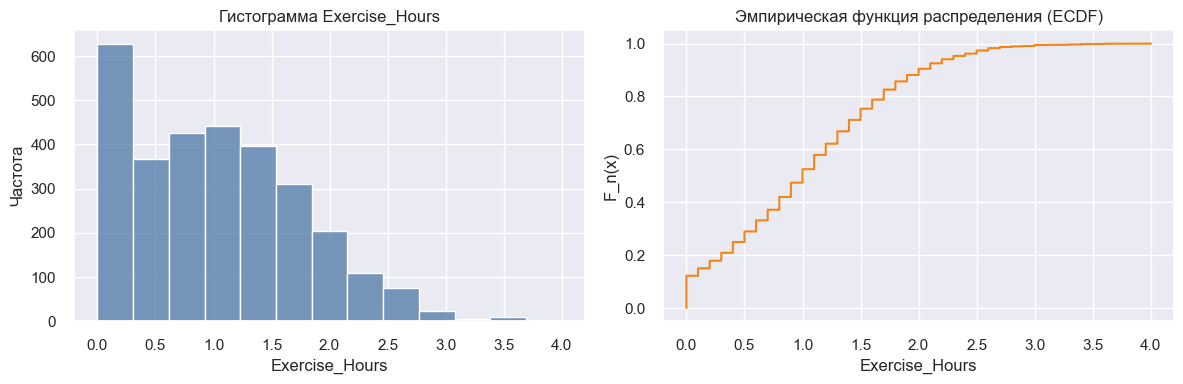

In [3]:
# Графики: гистограмма и эмпирическая функция распределения (EDF/ECDF)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Гистограмма
sns.histplot(x, kde=False, bins="sturges", ax=ax[0], color="#4c78a8", edgecolor="white")
ax[0].set_title("Гистограмма Exercise_Hours")
ax[0].set_xlabel("Exercise_Hours")
ax[0].set_ylabel("Частота")

# Эмпирическая функция распределения (ECDF)
xs = np.sort(x)
ys = np.arange(1, n + 1) / n
ax[1].step(xs, ys, where="post", color="#f58518")
ax[1].set_title("Эмпирическая функция распределения (ECDF)")
ax[1].set_xlabel("Exercise_Hours")
ax[1].set_ylabel("F_n(x)")

plt.tight_layout()
plt.show()


Анализ показал, что среднее значение составляет около 1.04 часа, а медиана равна 1 часу. Это говорит о том, что распределение достаточно симметрично и центрировано вокруг одного часа занятий. Однако мода равна нулю, что отражает значительную долю подростков, которые вовсе не занимаются физическими упражнениями. Квантили 0.25, 0.5 и 0.75 равны соответственно 0.5, 1.0 и 1.5, а интерквартильный размах составляет 1.0, что указывает на компактность распределения. Ассиметрия равна 0.44, то есть распределение слегка смещено вправо, а эксцесс равен -0.26, что свидетельствует о более плоской форме по сравнению с нормальным распределением. В целом данные демонстрируют умеренную асимметрию и наличие выраженной моды в нуле.

In [4]:
from math import erf, sqrt
from scipy.stats import chi2

# Стурджес: k = 1 + log2(n) (округлим)
k = int(np.ceil(1 + np.log2(n)))

# Границы интервалов по квантилям нормального с оценёнными параметрами
mu, sigma = mean, np.sqrt(var)
# Используем равновероятные интервалы по нормальному (чтобы E_j были близки)
qs = np.linspace(0, 1, k + 1)
bins = stats.norm.ppf(qs, loc=mu, scale=sigma)
bins[0] = min(bins[0], xs[0]) - 1e-6
bins[-1] = max(bins[-1], xs[-1]) + 1e-6

# Наблюдённые частоты
O, _ = np.histogram(x, bins=bins)

# Теоретические вероятности для интервалов p_j
def norm_cdf(t, mu, sigma):
    return 0.5 * (1 + erf((t - mu) / (sigma * sqrt(2))))

p = np.array([norm_cdf(bins[j+1], mu, sigma) - norm_cdf(bins[j], mu, sigma) for j in range(k)])
E = n * p

# Объединение интервалов с E_j < 5
O_adj, E_adj = [], []
accO, accE = 0, 0
for Oj, Ej in zip(O, E):
    accO += Oj
    accE += Ej
    if accE >= 5:
        O_adj.append(accO)
        E_adj.append(accE)
        accO, accE = 0, 0
# Если остались
if accE > 0:
    if len(E_adj) > 0:
        O_adj[-1] += accO
        E_adj[-1] += accE
    else:
        O_adj.append(accO)
        E_adj.append(accE)

O_adj = np.array(O_adj)
E_adj = np.array(E_adj)

chi2_stat = np.sum((O_adj - E_adj)**2 / E_adj)
k_eff = len(E_adj)
df_chi = k_eff - 1 - 2  # -2 за оценку mu, sigma
p_chi = 1 - chi2.cdf(chi2_stat, df=df_chi)

print("II. χ² критерий нормальности (реализация вручную):")
print(f"- χ² статистика: {chi2_stat:.4f}")
print(f"- Степени свободы: {df_chi}")
print(f"- p-value: {p_chi:.4f}")


II. χ² критерий нормальности (реализация вручную):
- χ² статистика: 810.1353
- Степени свободы: 10
- p-value: 0.0000


In [5]:
SE_skew = np.sqrt(6 / n)
SE_kurt = np.sqrt(24 / n)
Z_skew = skew / SE_skew
Z_kurt = kurt_excess / SE_kurt

print("II. Критерии ассиметрии и эксцесса:")
print(f"- Z_skew: {Z_skew:.3f} (SE={SE_skew:.3f})")
print(f"- Z_kurt: {Z_kurt:.3f} (SE={SE_kurt:.3f})")


II. Критерии ассиметрии и эксцесса:
- Z_skew: 9.808 (SE=0.045)
- Z_kurt: -2.879 (SE=0.089)


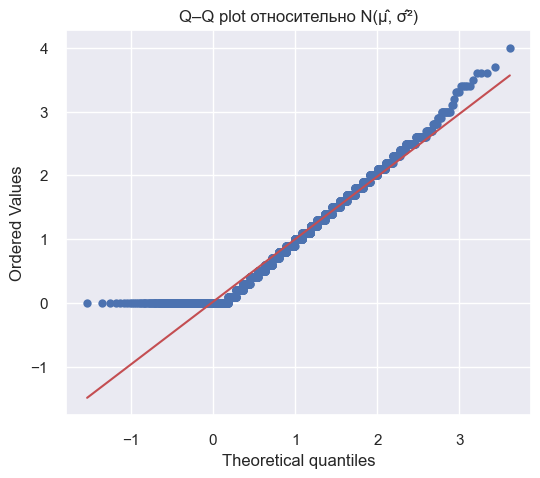

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))
stats.probplot(x, dist=stats.norm, sparams=(mean, np.sqrt(var)), plot=ax)
ax.set_title("Q–Q plot относительно N(μ̂, σ̂²)")
plt.show()


Проверка нормальности показала, что данные не соответствуют нормальному распределению. χ² критерий дал значение статистики около 810 при p-value, равном нулю, что однозначно отвергает гипотезу нормальности. Критерии ассиметрии и эксцесса также подтвердили это: Z-оценка для ассиметрии составила 9.8, а для эксцесса -2.9, что значительно выходит за пределы допустимого диапазона. Q–Q plot демонстрирует отклонения от прямой линии, особенно в хвостах, что подтверждает ненормальность распределения. Таким образом, исходные данные не могут считаться нормально распределёнными.


III. Обработка: усечение выбросов (IQR, винсоризация)
- Среднее: 1.0382
- Дисперсия: 0.5288
- Мода: 0.0000
- Медиана: 1.0000
- Квантили 0.25/0.5/0.75: 0.5000 / 1.0000 / 1.5000
- Ассиметрия: 0.3670, Эксцесс: -0.5357, IQR: 1.0000
- χ²: 357.1633, df=10, p=0.0000
- Z_skew: 8.206, Z_kurt: -5.989


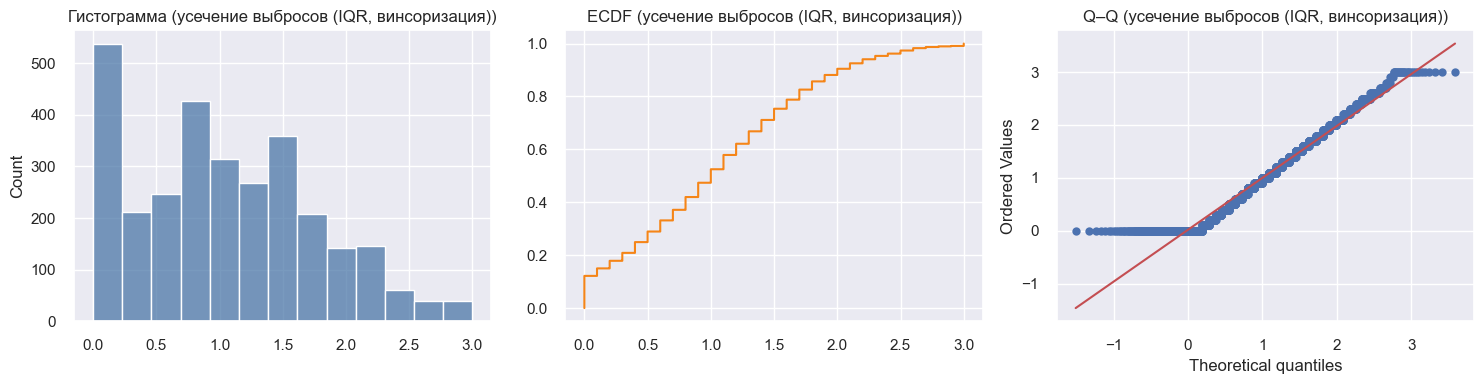


III. Обработка: стандартизация (z-score)
- Среднее: 0.0000
- Дисперсия: 1.0003
- Мода: -1.4168
- Медиана: -0.0554
- Квантили 0.25/0.5/0.75: -0.7361 / -0.0554 / 0.6254
- Ассиметрия: 0.4386, Эксцесс: -0.2575, IQR: 1.3615
- χ²: 810.1353, df=10, p=0.0000
- Z_skew: 9.808, Z_kurt: -2.879


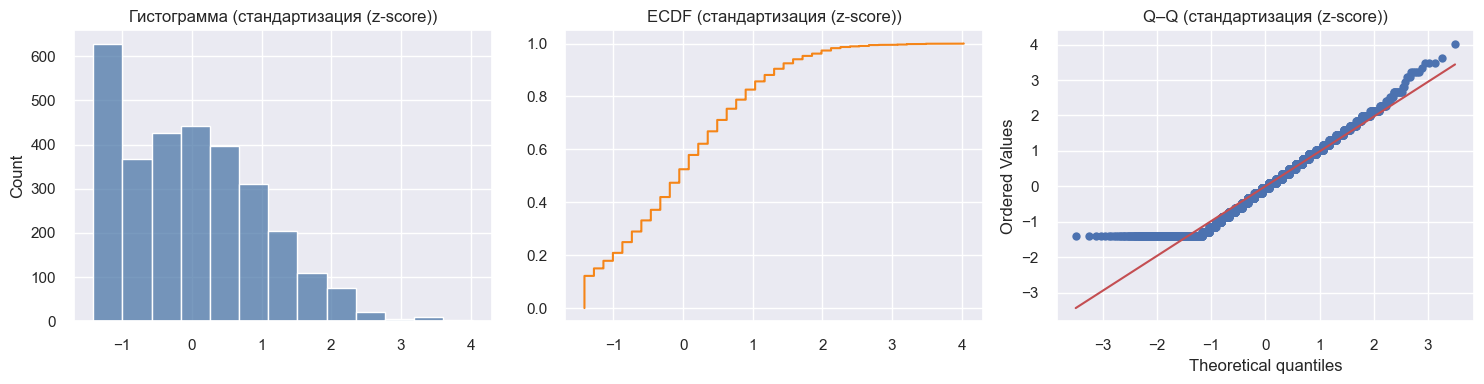


III. Обработка: Yeo–Johnson (PowerTransformer)
- Среднее: -0.0000
- Дисперсия: 1.0003
- Мода: -1.6179
- Медиана: 0.0662
- Квантили 0.25/0.5/0.75: -0.6804 / 0.0662 / 0.6969
- Ассиметрия: -0.0352, Эксцесс: -0.7945, IQR: 1.3773
- χ²: 301.1333, df=10, p=0.0000
- Z_skew: -0.786, Z_kurt: -8.883


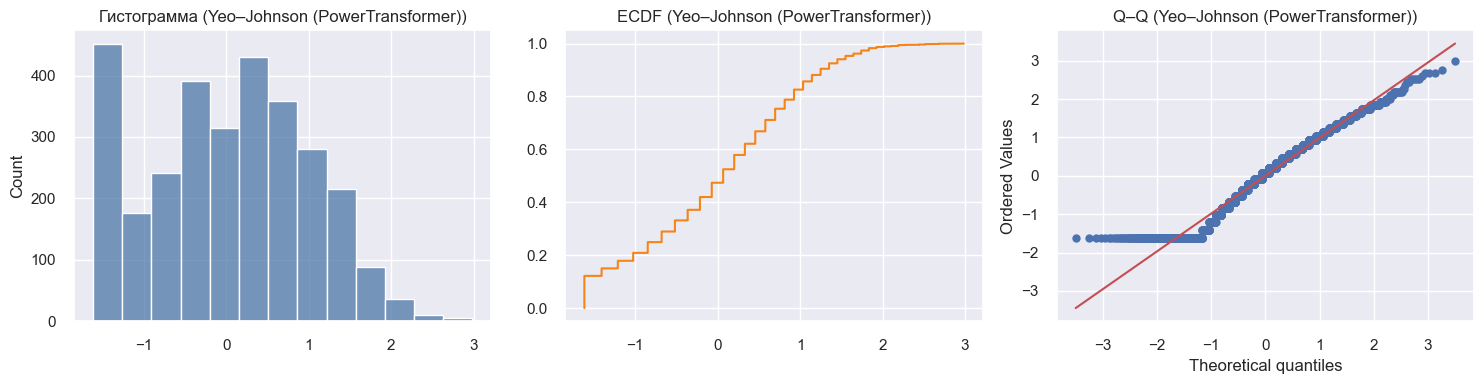

In [7]:
# 1) Усечение выбросов (винсоризация) по IQR
q1, q3 = np.quantile(x, [0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
x_wins = np.clip(x, lower, upper)

# 2) Стандартизация (z-score)
scaler = StandardScaler()
x_std = scaler.fit_transform(x.reshape(-1, 1)).ravel()

# 3) Логарифмирование (если все > 0)
if np.all(x > 0):
    x_log = np.log(x)
else:
    x_log = None

# 4) Yeo–Johnson (устойчива к нулям/отрицательным)
pt = PowerTransformer(method="yeo-johnson", standardize=True)
x_yj = pt.fit_transform(x.reshape(-1, 1)).ravel()

# Удобная функция для пересчёта показателей и тестов
def summarize_and_tests(x_new, title=""):
    n = len(x_new)
    mean = np.mean(x_new)
    var = np.var(x_new, ddof=1)
    median = np.median(x_new)
    mode = stats.mode(x_new, keepdims=True).mode[0]
    q25, q50, q75 = np.quantile(x_new, [0.25, 0.5, 0.75])
    iqr = q75 - q25
    skew = stats.skew(x_new, bias=False)
    kurt = stats.kurtosis(x_new, fisher=True, bias=False)

    print(f"\nIII. Обработка: {title}")
    print(f"- Среднее: {mean:.4f}")
    print(f"- Дисперсия: {var:.4f}")
    print(f"- Мода: {mode:.4f}")
    print(f"- Медиана: {median:.4f}")
    print(f"- Квантили 0.25/0.5/0.75: {q25:.4f} / {q50:.4f} / {q75:.4f}")
    print(f"- Ассиметрия: {skew:.4f}, Эксцесс: {kurt:.4f}, IQR: {iqr:.4f}")

    # χ² с тем же подходом (переоценим параметры)
    mu, sigma = mean, np.sqrt(var)
    xs = np.sort(x_new)
    k = int(np.ceil(1 + np.log2(n)))
    qs = np.linspace(0, 1, k + 1)
    bins = stats.norm.ppf(qs, loc=mu, scale=sigma)
    bins[0] = min(bins[0], xs[0]) - 1e-6
    bins[-1] = max(bins[-1], xs[-1]) + 1e-6
    O, _ = np.histogram(x_new, bins=bins)
    # Теоретические вероятности
    def norm_cdf(t, mu, sigma):
        return 0.5 * (1 + erf((t - mu) / (sigma * sqrt(2))))
    p = np.array([norm_cdf(bins[j+1], mu, sigma) - norm_cdf(bins[j], mu, sigma) for j in range(k)])
    E = n * p
    # Объединяем малые E_j
    O_adj, E_adj = [], []
    accO, accE = 0, 0
    for Oj, Ej in zip(O, E):
        accO += Oj
        accE += Ej
        if accE >= 5:
            O_adj.append(accO); E_adj.append(accE)
            accO, accE = 0, 0
    if accE > 0:
        if len(E_adj) > 0:
            O_adj[-1] += accO; E_adj[-1] += accE
        else:
            O_adj.append(accO); E_adj.append(accE)
    O_adj = np.array(O_adj); E_adj = np.array(E_adj)
    chi2_stat = np.sum((O_adj - E_adj)**2 / E_adj)
    df_chi = len(E_adj) - 1 - 2
    p_chi = 1 - stats.chi2.cdf(chi2_stat, df_chi)

    SE_skew = np.sqrt(6 / n)
    SE_kurt = np.sqrt(24 / n)
    Z_skew = skew / SE_skew
    Z_kurt = kurt / SE_kurt

    print(f"- χ²: {chi2_stat:.4f}, df={df_chi}, p={p_chi:.4f}")
    print(f"- Z_skew: {Z_skew:.3f}, Z_kurt: {Z_kurt:.3f}")

    # Быстрые графики
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(x_new, bins="sturges", ax=ax[0], color="#4c78a8", edgecolor="white")
    ax[0].set_title(f"Гистограмма ({title})")
    xs = np.sort(x_new); ys = np.arange(1, n + 1) / n
    ax[1].step(xs, ys, where="post", color="#f58518")
    ax[1].set_title(f"ECDF ({title})")
    stats.probplot(x_new, dist=stats.norm, sparams=(mean, np.sqrt(var)), plot=ax[2])
    ax[2].set_title(f"Q–Q ({title})")
    plt.tight_layout(); plt.show()

# Применяем
summarize_and_tests(x_wins, "усечение выбросов (IQR, винсоризация)")
summarize_and_tests(x_std, "стандартизация (z-score)")
if x_log is not None:
    summarize_and_tests(x_log, "логарифмирование (ln)")
summarize_and_tests(x_yj, "Yeo–Johnson (PowerTransformer)")


Попытки привести данные к нормальному виду показали разные результаты. Усечение выбросов немного снизило ассиметрию и эксцесс, но χ² критерий всё равно отверг нормальность, а распределение осталось далёким от нормального. Стандартизация изменила масштаб, но не форму, поэтому показатели остались прежними. Наиболее заметный эффект дала трансформация Yeo–Johnson: ассиметрия практически исчезла (≈0), распределение стало более симметричным, однако эксцесс остался отрицательным и значительным, что говорит о сохранении плоской формы. χ² критерий и здесь отверг нормальность, но визуально распределение стало ближе к нормальному. Таким образом, обработка улучшила характеристики, особенно симметрию, но полностью нормализовать данные не удалось.

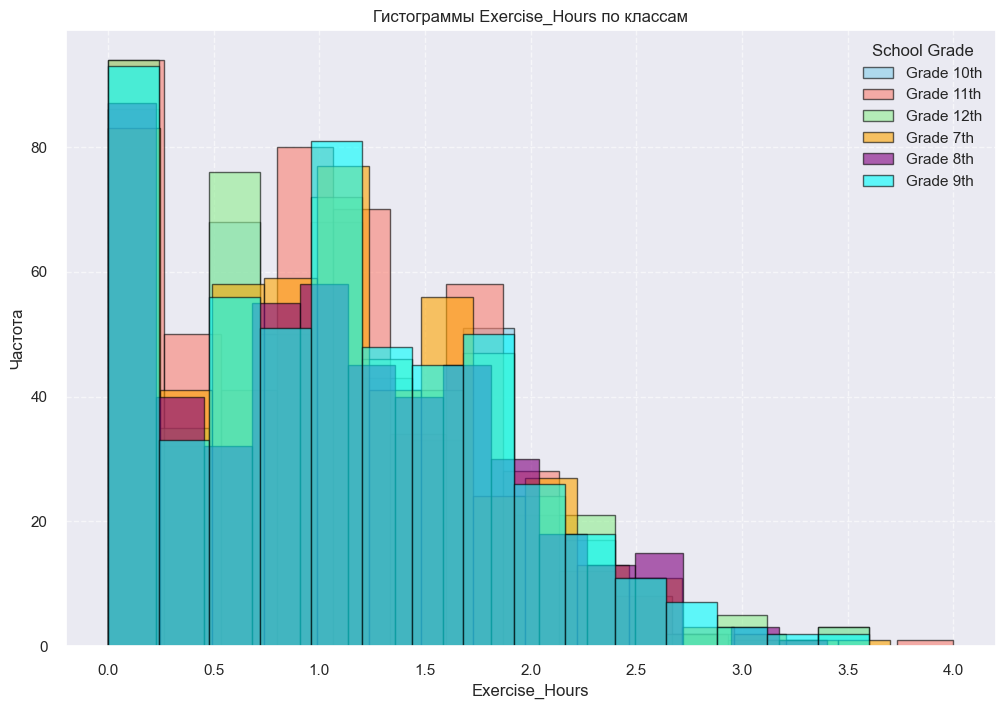


=== IV. Статистики по группам 'School_Grade' ===
                  mean       var
School_Grade                    
10th          1.042505  0.536523
11th          0.979541  0.486652
12th          1.045936  0.564155
7th           1.029577  0.532410
8th           1.062033  0.551674
9th           1.080228  0.561665


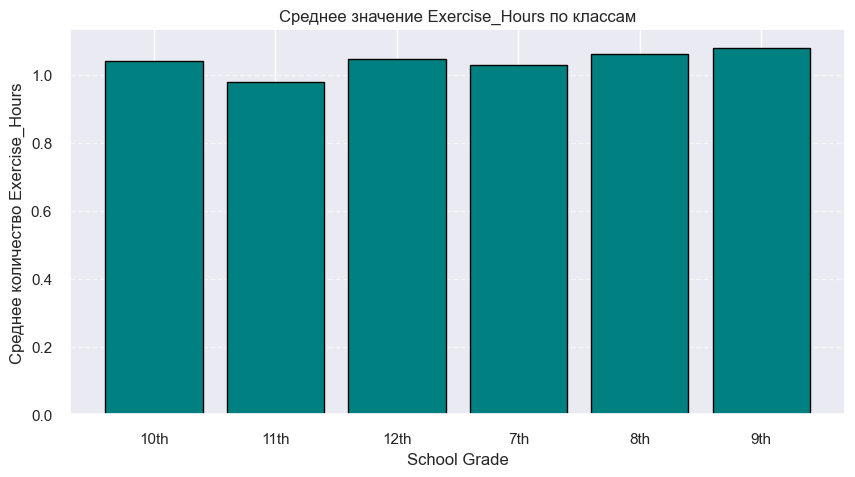

,School_Grade,mean,var
3,7th,1.029577,0.532410
4,8th,1.062033,0.551674
5,9th,1.080228,0.561665
0,10th,1.042505,0.536523
1,11th,0.979541,0.486652
2,12th,1.045936,0.564155


In [8]:
# Группировка по School_Grade
groups = df.groupby("School_Grade")["Exercise_Hours"]

# IV.1 Гистограммы на одном графике
plt.figure(figsize=(12, 8))
colors = ["skyblue", "salmon", "lightgreen", "orange", "purple", "cyan", "magenta"]

for i, (grade, values) in enumerate(groups):
    plt.hist(
        values,
        bins=15,
        alpha=0.6,
        label=f"Grade {grade}",
        color=colors[i % len(colors)],
        edgecolor="black"
    )

plt.title("Гистограммы Exercise_Hours по классам")
plt.xlabel("Exercise_Hours")
plt.ylabel("Частота")
plt.legend(title="School Grade")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# IV.2 Среднее и дисперсия внутри групп
group_stats = groups.agg(["mean", "var"])
print("\n=== IV. Статистики по группам 'School_Grade' ===")
print(group_stats)

# Визуализация средних значений
plt.figure(figsize=(10, 5))
plt.bar(group_stats.index, group_stats["mean"], color="teal", edgecolor="black")
plt.title("Среднее значение Exercise_Hours по классам")
plt.xlabel("School Grade")
plt.ylabel("Среднее количество Exercise_Hours")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Сортировка статистик по номеру класса
group_stats_sorted = group_stats.reset_index()
group_stats_sorted["Grade_Num"] = group_stats_sorted["School_Grade"].str.extract(r"(\d+)").astype(int)
group_stats_sorted = group_stats_sorted.sort_values(by="Grade_Num").drop(columns="Grade_Num")

group_stats_sorted


При группировке данных по классам оказалось, что средние значения во всех группах находятся в диапазоне от 0.98 до 1.08 часов, а дисперсия колеблется от 0.49 до 0.56. Это говорит о том, что различия между классами минимальны. На гистограммах, построенных для каждой группы отдельно, видно, что распределения имеют схожую форму: мода в нуле, пик около одного часа и умеренный разброс. Незначительные отличия проявляются в том, что у девятиклассников среднее и дисперсия чуть выше, а у одиннадцатиклассников — немного ниже. В целом же распределения по классам практически идентичны, и можно заключить, что уровень физической активности в часах упражнений не зависит существенно от класса.